In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, os
import random
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras import activations
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from scipy.stats import bernoulli

# import deap
from deap import base, creator, tools, algorithms

from bitstring import BitArray

from elitism import eaSimpleWithElitism, main

Elitism succesfully imported


In [3]:
np.random.seed(0)

# tf.config.optimizer.set_jit(True)
scaler = StandardScaler()

In [4]:
url = "https://raw.githubusercontent.com/igomezv/neurapprox/main/SDSS/star_classification.csv"
data = pd.read_csv(url)
cols = ['alpha','delta','u','g','r','i','z','redshift','class']
data = data[cols]
data.head()

,alpha,delta,u,g,r,i,z,redshift,class
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY


In [5]:
data["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in data["class"]]
print(data.head())
data = data.to_numpy()

        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   
3  338.741038  -0.402828  22.13682  23.77656  21.61162  20.50454  19.25010   
4  345.282593  21.183866  19.43718  17.58028  16.49747  15.97711  15.54461   

   redshift  class  
0  0.634794      0  
1  0.779136      0  
2  0.644195      0  
3  0.932346      0  
4  0.116123      0  


In [6]:
# Activation function layers

# f1 = lambda x: Dense(x, activation='relu')      #ReLU
# f2 = lambda x: Dense(x, activation='elu')       #ELU
# f3 = lambda x: keras.layers.LeakyReLU(0.3)      #LReLU
# f4 = lambda x: Dense(x, kernel_initializer='lecun_normal', activation='selu')   #SELU

# f_names = ["ReLU", "ELU", "LReLU", "SELU"]

In [31]:
SC_DEEP       = np.array([2,3,4])                           # Number of deep layers (8)
SC_NUM_UNITS  = np.array([50,100,200]) # Number of fully conected neurons (16)
SC_LEARNING   = np.array([1e-5,1e-4,5e-3])   # Learning rates (8)
# SC_BATCH      = np.array([64,128,256,512])                            # Batch sizes (4)
# SC_ACTIVATION = [f1, f2, f3, f4]                                      # Activation function layers (2)

my_callbacks = [tf.keras.callbacks.EarlyStopping(
                               monitor='val_loss', mode='min',
                               min_delta=0, 
                               patience=6,
                               verbose=1,
                            #    baseline=0,
                               restore_best_weights=1)
#                 keras.callbacks.TensorBoard(
#                                log_dir='./logs'),
#                 keras.callbacks.ReduceLROnPlateau(
#                                monitor='val_loss', factor=0.5,
#                                patience=6, min_lr=0,
#                                verbose=1)
               ] 
    
epochs = 15
# epochs = 3

In [32]:
# Divide data into X and Y and implement hot_ones in Y
def prepare_dataset(data):
    X, Y = np.empty((0)), np.empty((0))
    X = data[:,0:8]
    Y = data[:,8]
    Y = to_categorical(Y, num_classes=3)
    return X, Y

In [33]:
# Split dataset into train, validation and test sets
X,Y = prepare_dataset(data)

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_, X_test, y_, Y_test = split(X, Y, test_size = ratio_test, random_state=0)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, Y_train, Y_val = split(x_, y_, test_size=ratio_val_adjusted, random_state=0)

# Normalize and scale the input sets.
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)
X_val   = scaler.transform(X_val)

In [66]:
def train_evaluate(ga_individual_solution):   
    t = time.time()
    t_total = 0
    
    # Decode GA solution to integer for window_size and num_units
    deep_layers_bits   = BitArray(ga_individual_solution[0:1])     # (8)
    num_units_bits     = BitArray(ga_individual_solution[1:2])     # (16)
    learning_rate_bits = BitArray(ga_individual_solution[2:3])    # (8)
# #     batch_size_bits    = BitArray(ga_individual_solution[10:12])   # (4)
# #     activation_f_bits  = BitArray(ga_individual_solution[12:13])   # (2)   Solo se consideran las 2 primeras
    
    deep_layers   = SC_DEEP[deep_layers_bits.uint]
    num_units     = SC_NUM_UNITS[num_units_bits.uint]
    learning_rate = SC_LEARNING[learning_rate_bits.uint]
#     batch_size   = SC_BATCH[batch_size_bits.uint]
#     activation_f  = SC_ACTIVATION[activation_f_bits.uint]

    
    print('\n--------------- Starting trial:', population_size*(max_generations+1)-len(ss), "---------------")
    print('Deep layers:',deep_layers,', Number of neurons:',num_units,", Learning rate:",learning_rate)
#     print("-------------------------------------------------")
    
    # Train model and predict on validation set
    model = tf.keras.Sequential()
    model.add(Input(shape=(int(X_train.shape[1]),)))
    model.add(Dense(num_units, input_shape=(int(X_train.shape[1]),)))
    
    for i in range(deep_layers):        
        model.add(Dense(num_units, activation='relu'))
#             model.add(keras.layers.Dropout(0.3))
    model.add(Dense(3, activation=tf.nn.softmax))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-3)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=my_callbacks, batch_size=128, shuffle=1, verbose=0)
    
    loss, score = model.evaluate(X_val, Y_val)    
    t = time.time()-t
    ss.pop(0)
    print("Accuracy:", score, ", Elapsed time:", t)
    print("-------------------------------------------------\n")
#     print(loss, score)

    datos.append([deep_layers, num_units, learning_rate, loss, score, t])
    
    return loss,

In [67]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [68]:
def geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k):
    
    # Genetic Algorithm constants:
    P_CROSSOVER = 0.9        # probability for crossover
    P_MUTATION = 0.3         # probability for mutating an individual
    HALL_OF_FAME_SIZE = 1    # Best individuals that pass to the other generation
    
    # set the random seed:
    toolbox = base.Toolbox()

    # As we are trying to minimize the RMSE score, that's why using -1.0. 
    # In case, when you want to maximize accuracy for instance, use 1.0
    creator.create('FitnessMin', base.Fitness, weights = [-1.0])
    creator.create('Individual', list , fitness = creator.FitnessMin)

    # create the individual operator to fill up an Individual instance:
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)

    # create the population operator to generate a list of individuals:
    toolbox.register('population', tools.initRepeat, list , toolbox.individual)

    # genetic operators:
    toolbox.register('evaluate', train_evaluate)
    toolbox.register('select', tools.selTournament, tournsize = 2)
    toolbox.register('mutate', tools.mutFlipBit, indpb = 0.11)
    toolbox.register('mate', tools.cxUniform, indpb = 0.5)
    
    # create initial population (generation 0):
    population = toolbox.population(n=population_size)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # Genetic Algorithm flow with elitism:
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=max_generations, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    # extract statistics:
    minFitnessValues, meanFitnessValues, maxFitnessValues = logbook.select("min", "max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='blue', label="Min")
    plt.plot(meanFitnessValues, color='green', label="Mean")
    plt.plot(maxFitnessValues, color='red', label="Max")
    plt.xlabel('Generation'); plt.ylabel('Max / Min / Average Fitness')
    plt.legend()
    plt.title('Max, Min and Average fitness over Generations')
    plt.show()
    
    best_population = tools.selBest(population,k = k)
    return best_population


--------------- Starting trial: 1 ---------------
Deep layers: 2 , Number of neurons: 50 , Learning rate: 1e-05
313/313 [==============================] - 0s 912us/step - loss: 0.3684 - accuracy: 0.8886
Accuracy: 0.8885999917984009 , Elapsed time: 12.1421537399292
-------------------------------------------------


--------------- Starting trial: 2 ---------------
Deep layers: 2 , Number of neurons: 50 , Learning rate: 1e-05
313/313 [==============================] - 0s 853us/step - loss: 0.3810 - accuracy: 0.8871
Accuracy: 0.8870999813079834 , Elapsed time: 13.32134747505188
-------------------------------------------------


--------------- Starting trial: 3 ---------------
Deep layers: 3 , Number of neurons: 50 , Learning rate: 0.0001
313/313 [==============================] - 0s 967us/step - loss: 0.1162 - accuracy: 0.9654
Accuracy: 0.965399980545044 , Elapsed time: 13.67304015159607
-------------------------------------------------


--------------- Starting trial: 4 ------------

313/313 [==============================] - 0s 917us/step - loss: 0.2388 - accuracy: 0.9176
Accuracy: 0.9175999760627747 , Elapsed time: 21.49345874786377
-------------------------------------------------


--------------- Starting trial: 19 ---------------
Deep layers: 3 , Number of neurons: 50 , Learning rate: 1e-05
313/313 [==============================] - 0s 955us/step - loss: 0.3333 - accuracy: 0.8947
Accuracy: 0.8946999907493591 , Elapsed time: 16.233866214752197
-------------------------------------------------

1  	9     	0.110198	0.239803	0.362376

--------------- Starting trial: 20 ---------------
Deep layers: 2 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 1ms/step - loss: 0.1161 - accuracy: 0.9650
Accuracy: 0.9649999737739563 , Elapsed time: 18.16201663017273
-------------------------------------------------


--------------- Starting trial: 21 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
31

313/313 [==============================] - 0s 1ms/step - loss: 0.1142 - accuracy: 0.9647
Accuracy: 0.9646999835968018 , Elapsed time: 18.41313123703003
-------------------------------------------------

3  	8     	0.107205	0.148528	0.325096

--------------- Starting trial: 36 ---------------
Deep layers: 2 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 1ms/step - loss: 0.1176 - accuracy: 0.9649
Accuracy: 0.964900016784668 , Elapsed time: 18.25692319869995
-------------------------------------------------


--------------- Starting trial: 37 ---------------
Deep layers: 2 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 1ms/step - loss: 0.1162 - accuracy: 0.9637
Accuracy: 0.963699996471405 , Elapsed time: 18.93120837211609
-------------------------------------------------


--------------- Starting trial: 38 ---------------
Deep layers: 2 , Number of neurons: 50 , Learning rate: 0.0001
313/313 

313/313 [==============================] - 0s 980us/step - loss: 0.1092 - accuracy: 0.9667
Accuracy: 0.96670001745224 , Elapsed time: 20.840423345565796
-------------------------------------------------


--------------- Starting trial: 53 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 1ms/step - loss: 0.1146 - accuracy: 0.9670
Accuracy: 0.9670000076293945 , Elapsed time: 21.395034313201904
-------------------------------------------------


--------------- Starting trial: 54 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 983us/step - loss: 0.1074 - accuracy: 0.9677
Accuracy: 0.9677000045776367 , Elapsed time: 22.690168857574463
-------------------------------------------------


--------------- Starting trial: 55 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 1e-05
313/313 [==============================

313/313 [==============================] - 0s 1ms/step - loss: 0.1078 - accuracy: 0.9691
Accuracy: 0.9690999984741211 , Elapsed time: 20.168855667114258
-------------------------------------------------


--------------- Starting trial: 70 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 1ms/step - loss: 0.1091 - accuracy: 0.9660
Accuracy: 0.9660000205039978 , Elapsed time: 20.13062620162964
-------------------------------------------------


--------------- Starting trial: 71 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 940us/step - loss: 0.1080 - accuracy: 0.9664
Accuracy: 0.9664000272750854 , Elapsed time: 24.184829235076904
-------------------------------------------------


--------------- Starting trial: 72 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================

313/313 [==============================] - 0s 1ms/step - loss: 0.1078 - accuracy: 0.9667
Accuracy: 0.96670001745224 , Elapsed time: 22.207363843917847
-------------------------------------------------


--------------- Starting trial: 87 ---------------
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001
313/313 [==============================] - 0s 960us/step - loss: 0.1072 - accuracy: 0.9672
Accuracy: 0.967199981212616 , Elapsed time: 22.379618167877197
-------------------------------------------------

10 	6     	0.107171	0.10806 	0.112172
-- Best Individual =  [1, 1, 1, 1, 0, 1, 1, 1, 0, 1]
-- Best Fitness =  0.1071707010269165


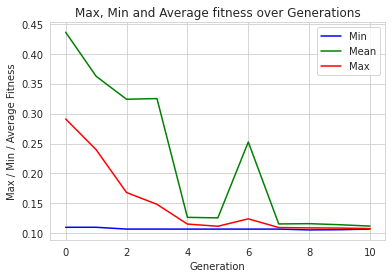

Total elapsed time: 28.04579256772995 minutes


In [69]:
population_size = 10   # max of individuals per generation
max_generations = 10   # number of generations
gene_length = 10       # lenght of the gene, depends on how many hiperparameters are tested  
k = 1;                 # num. of finalist individuals

if __name__ == "__main__":
    t = time.time(); 
    datos = [];
    ss = [i for i in range(1,population_size*(max_generations+1))]
    best_population = geneticAlgorithm_with_elitism(population_size, max_generations, gene_length, k)
    print("Total elapsed time:", (time.time()-t)/60, "minutes")

In [71]:
best_deep_layers   = []
best_num_units     = []
best_learning_rate = []
# best_batch_size    = []
# best_activation_f  = []
best_f_names       = []

t = 0

for bi in best_population:
    deep_layers_bits   = BitArray(bi[0:1])    # (8)
    num_units_bits     = BitArray(bi[1:2])    # (16)
    learning_rate_bits = BitArray(bi[2:3])   # (8)
#     batch_size_bits    = BitArray(bi[10:12])  # (4)
#     activation_f_bits  = BitArray(bi[12:13])  # (2)
    t += 1 
    
    best_deep_layers.append(SC_DEEP[deep_layers_bits.uint])
    best_num_units.append(SC_NUM_UNITS[num_units_bits.uint])
    best_learning_rate.append(SC_LEARNING[learning_rate_bits.uint])
#     best_batch_size.append(SC_BATCH[batch_size_bits.uint])
#     best_activation_f.append(SC_ACTIVATION[activation_f_bits.uint])
#     best_f_names.append(f_names[activation_f_bits.uint])
    
    print('k=',t,'\nDeep layers:', best_deep_layers[-1], ', Number of neurons:', best_num_units[-1], ', Learning rate:', best_learning_rate[-1])

k= 1 
Deep layers: 3 , Number of neurons: 100 , Learning rate: 0.0001


In [74]:
filename = "historial_sdss.txt"
df = pd.DataFrame(datos, columns = ["Deep layers", "Num units", "Learning rate", "Loss", "Accuracy", "Elapsed time"])

df.sort_values(by=["Accuracy", "Elapsed time"], ascending=[0,1], ignore_index=True, inplace=True)

df.to_csv(filename, header=True, index=False, sep='\t', mode='w') # a=append, w=overwrite
df

,Deep layers,Num units,Learning rate,Loss,Accuracy,Elapsed time
0,3,100,0.00010,0.107804,0.9691,20.168856
1,3,100,0.00010,0.108900,0.9690,21.993806
2,3,100,0.00010,0.106158,0.9685,21.821555
3,3,100,0.00010,0.107591,0.9684,21.814904
4,3,100,0.00010,0.107511,0.9684,22.716610
...,...,...,...,...,...,...
82,2,50,0.00001,0.381049,0.8871,13.321347
83,2,50,0.00001,0.390456,0.8860,13.564182
84,2,50,0.00001,0.362376,0.8854,14.206108
85,2,50,0.00001,0.359580,0.8852,12.254668


In [82]:
total_time = float(np.sum(df[["Elapsed time"]])/60)

print("Elapsed time {:.3f} minutes".format(total_time))

Elapsed time 28.040 minutes
